In [42]:
import networkx as nx
import os
import matplotlib.pyplot as plt
from networkx.algorithms.dominating import is_dominating_set
from networkx.algorithms.bipartite import is_bipartite
from networkx.algorithms.bipartite.matching import *
from networkx.algorithms.bipartite.covering import *

In [79]:
def load_graph(name):
    with open(name, "r") as f:
        state = 0
        G = None
        for l in f:
            if state == 0:  # Header nb of nodes
                state = 1
            elif state == 1:  # Nb of nodes
                nodes = int(l)
                state = 2
            elif state == 2:  # Header position
                i = 0
                state = 3
            elif state == 3:  # Position
                i += 1
                if i >= nodes:
                    state = 4
            elif state == 4:  # Header node weight
                i = 0
                state = 5
                G = nx.Graph()
            elif state == 5:  # Node weight
                G.add_node(i, weight=int(l))
                i += 1
                if i >= nodes:
                    state = 6
            elif state == 6:  # Header edge
                i = 0
                state = 7
            elif state == 7:
                if i > nodes:
                    pass
                else:
                    edges = l.strip().split(" ")
                    for j, w in enumerate(edges):
                        w = int(w)
                        if w == 1 and (not i == j):
                            G.add_edge(i, j)
                    i += 1

        return G

In [43]:
folder_path = "./rep_data_set/"
filename= "graph_50_50"

In [44]:
g = nx.read_adjlist(os.path.join(folder_path, filename))

In [45]:
graph_loaded = load_graph(folder_path+filename)

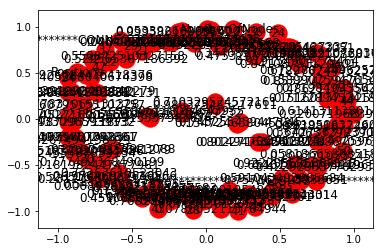

In [46]:
nx.draw_networkx(g)

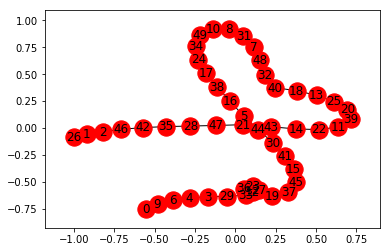

In [47]:
nx.draw_networkx(graph_loaded)

In [48]:
def order_graph(g) :
    """
    sort the graph according to the succession of nodes
    """
    first_node = list(g.nodes)[0] 
    new_graph = [first_node] 
    new_graph.append(list(g[first_node])[0]) 
    while len(new_graph) != g.order() :
        adjacent = list(g[new_graph[-1]]) 
        adjacent.remove(new_graph[-2]) 
        new_graph.append(adjacent[0]) 
    return new_graph

def cycle_dominant(g):
    dominant_set = set()
    ordered_graph = order_graph(g)
    for i in range(0, len(ordered_graph), 3):
        dominant_set.add(ordered_graph[i])
    return dominant_set

def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    all_nodes = set(g)
    adjacent_nb = {} 
    for node in all_nodes :
        adjacent_nb[g.degree[node]] = node
    if len(adjacent_nb) == 1 and (g.number_of_nodes() == g.number_of_edges()) : 
        return cycle_dominant(g)
    else :
        max_adjacent = max(adjacent_nb.keys()) 
        max_node = adjacent_nb[max_adjacent]        
        dominating_set = {max_node}
        not_selected = all_nodes - {max_node} 
        all_nodes = all_nodes - set(g[max_node]) - {max_node} 
        g = g.subgraph(not_selected) 
        while all_nodes :
            adjacent_nb = {} 
            for node in not_selected :
                remaining_adjacent = []
                for node2 in list(g[node]) :
                    if node2 in all_nodes :
                        remaining_adjacent.append(node2)
                adjacent_nb[len(remaining_adjacent)] = node
            if len(adjacent_nb) == 1 and (g.number_of_nodes() == g.number_of_edges()) :
                dominating_set |= cycle_dominant(g)
                return dominating_set
            max_adjacent = max(adjacent_nb.keys())
            max_node = adjacent_nb[max_adjacent]
            dominating_set.add(max_node)
            not_selected = not_selected - {max_node}
            all_nodes = all_nodes - set(g[max_node]) - {max_node}
            g = g.subgraph(not_selected)
    return dominating_set

In [49]:
for filename in os.listdir(folder_path):
        graph_loaded = load_graph(os.path.join(folder_path, filename))
        #print(dominant(graph_loaded))

In [50]:
#nx.draw_networkx(dominant(graph_loaded))

In [51]:
def dominant_baseline(G, start_with=None):
    r"""Finds a dominating set for the graph G.
    A *dominating set* for a graph with node set *V* is a subset *D* of
    *V* such that every node not in *D* is adjacent to at least one
    member of *D* [1]_.
    Parameters
    ----------
    G : NetworkX graph
    start_with : node (default=None)
        Node to use as a starting point for the algorithm.
    Returns
    -------
    D : set
        A dominating set for G.
    Notes
    -----
    This function is an implementation of algorithm 7 in [2]_ which
    finds some dominating set, not necessarily the smallest one.
    See also
    --------
    is_dominating_set
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Dominating_set
    .. [2] Abdol-Hossein Esfahanian. Connectivity Algorithms.
        http://www.cse.msu.edu/~cse835/Papers/Graph_connectivity_revised.pdf
    """
    all_nodes = set(G)
    if start_with is None:
        start_with = nx.utils.arbitrary_element(all_nodes)
    if start_with not in G:
        raise nx.NetworkXError('node {} is not in G'.format(start_with))
    dominating_set = {start_with}
    dominated_nodes = set(G[start_with])
    remaining_nodes = all_nodes - dominated_nodes - dominating_set
    while remaining_nodes:
        # Choose an arbitrary node and determine its undominated neighbors.
        v = remaining_nodes.pop()
        undominated_neighbors = set(G[v]) - dominating_set
        # Add the node to the dominating set and the neighbors to the
        # dominated set. Finally, remove all of those nodes from the set
        # of remaining nodes.
        dominating_set.add(v)
        dominated_nodes |= undominated_neighbors
        remaining_nodes -= undominated_neighbors
    return dominating_set

In [193]:
def evaluate(d,g):
    score = 0
    for node in d:
        score += g.nodes[node]['weight']
    return  score

def ratio(g, dominating_set, remaining_nodes):
    rank = {}
    if dominating_set == {}:
        for node in g:
            rank[node] = len(set(g[node]))/g.nodes[node]['weight']
    else:
        for node in remaining_nodes:
            rank[node] = len(set(g[node]) - dominating_set)/g.nodes[node]['weight']
    return rank

def dominant_ratio_per_uncovered_node(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    all_nodes = set(g)
    start_with = sorted(ratio(g,{},{}).items(), key=lambda item: item[1]).pop()[0]
    dominating_set = {start_with}
    dominated_nodes = set(g[start_with])
    remaining_nodes = all_nodes - dominated_nodes - dominating_set
    while remaining_nodes:
        v = sorted(ratio(g,dominated_nodes,remaining_nodes).items(), key=lambda item: item[1]).pop()[0]
        undominated_neighbors = set(g[v]) - dominating_set
        dominating_set.add(v)
        dominated_nodes |= undominated_neighbors
        remaining_nodes -= undominated_neighbors|{v}
    return dominating_set


def dominant_ratio_per_remaining_node(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    all_nodes = set(g)
    start_with = sorted(ratio(g,{},{}).items(), key=lambda item: item[1]).pop()[0]
    dominating_set = {start_with}
    dominated_nodes = set(g[start_with])
    remaining_nodes = all_nodes - dominated_nodes - dominating_set
    while remaining_nodes:
        v = sorted(ratio(g,dominated_nodes,all_nodes - dominating_set).items(), key=lambda item: item[1]).pop()[0]
        undominated_neighbors = set(g[v]) - dominating_set
        dominating_set.add(v)
        dominated_nodes |= undominated_neighbors
        remaining_nodes -= undominated_neighbors|{v}
    return dominating_set


def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    d = dominant_ratio_per_uncovered_node(g)
    d_min = dominant_ratio_per_remaining_node(g)
    score = evaluate(d,g)
    score_min = evaluate(d_min,g)
    if score_min < score:
        return d_min
    else:
        return d

In [194]:
input_dir = os.path.abspath('rep_data_set')
t = 0
baseline = 0

for graph_filename in sorted(os.listdir(input_dir)):
    s = 0
    # importer le graphe
    g = load_graph(os.path.join(input_dir, graph_filename))

    # calcul du dominant
    B = sorted(dominant_ratio_per_uncovered_node(g), key=lambda x: int(x))
    D = sorted(dominant(g), key=lambda x: int(x))
    
    if not is_dominating_set(g, D):
        print('[DOMINATION ERROR]: Not a dominating set')
    
    for node in B:
        baseline += g.nodes[node]['weight']
    
    for node in D:
        s += g.nodes[node]['weight']
        t += g.nodes[node]['weight']
        
    print(graph_filename)        
    print(D)
    print("Sum of dominant nodes: " + str(s))
    print("Nb of dominant nodes: " + str(len(D)) + '/' + str(len(g)))
    
    print('-------')
    
print(str(t) + ' vs baseline: ' + str(baseline))

graph_100_100
[0, 7, 8, 11, 14, 21, 22, 23, 24, 26, 31, 33, 34, 35, 36, 38, 40, 41, 45, 46, 49, 50, 55, 58, 60, 62, 63, 64, 67, 69, 77, 78, 79, 80, 81, 82, 83, 86, 87, 90, 93, 96, 97]
Sum of dominant nodes: 1269
Nb of dominant nodes: 43/100
-------
graph_100_1000
[22, 23, 28, 35, 36, 49, 62, 69, 77, 80, 86, 93, 96]
Sum of dominant nodes: 311
Nb of dominant nodes: 13/100
-------
graph_100_250
[0, 3, 6, 11, 12, 14, 15, 21, 22, 31, 35, 37, 38, 40, 44, 50, 51, 56, 64, 69, 73, 76, 78, 80, 82, 86, 87, 90, 91]
Sum of dominant nodes: 885
Nb of dominant nodes: 29/100
-------
graph_100_500
[11, 22, 23, 24, 31, 33, 35, 36, 41, 49, 54, 64, 72, 75, 79, 80, 86, 95]
Sum of dominant nodes: 454
Nb of dominant nodes: 18/100
-------
graph_250_1000
[0, 13, 21, 22, 23, 24, 31, 35, 41, 44, 49, 50, 51, 55, 57, 61, 64, 77, 79, 82, 90, 96, 99, 103, 106, 115, 116, 117, 118, 131, 135, 144, 149, 157, 167, 169, 170, 171, 172, 180, 182, 183, 184, 185, 187, 191, 193, 194, 201, 204, 219, 223, 232, 237, 240, 247]
Sum 